In [7]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

# ## Load and Prepare Data
data_path = Path().cwd().parent / "dataset" / "raw" 

calendar = pd.read_csv(data_path / "calendar.csv")
sales = pd.read_csv(data_path / "sales_train.csv")
prices = pd.read_csv(data_path / "sell_prices.csv")

In [3]:
calendar_events = calendar[["date", "event_type_1"]].copy()
calendar_events["date"] = pd.to_datetime(calendar_events["date"])
calendar_events["event_type_1"] = calendar_events["event_type_1"].fillna("None")

event_dummies = pd.get_dummies(calendar_events["event_type_1"])
calendar_events = pd.concat([calendar_events["date"], event_dummies], axis=1)
sales_melted = sales.melt(
    id_vars=["item_id", "dept_id", "cat_id"], var_name="d", value_name="sales"
)
sales_merged = sales_melted.merge(calendar[["d", "date"]], on="d", how="left")
sales_merged["date"] = pd.to_datetime(sales_merged["date"])
daily_sales = sales_merged.groupby("date")["sales"].sum().reset_index()
daily_sales.rename(columns={"date": "ds", "sales": "y"}, inplace=True)

# Event flags
df_train = daily_sales.merge(
    calendar_events, left_on="ds", right_on="date", how="left"
).drop(columns="date")

df_train.fillna(0, inplace=True)

print(df_train.head())

          ds     y  Cultural  National  None  Religious  Sporting
0 2011-01-29  4739     False     False  True      False     False
1 2011-01-30  4827     False     False  True      False     False
2 2011-01-31  3785     False     False  True      False     False
3 2011-02-01  4232     False     False  True      False     False
4 2011-02-02  3817     False     False  True      False     False


23:43:23 - cmdstanpy - INFO - Chain [1] start processing
23:43:23 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 469.64
MAPE: 5.78%


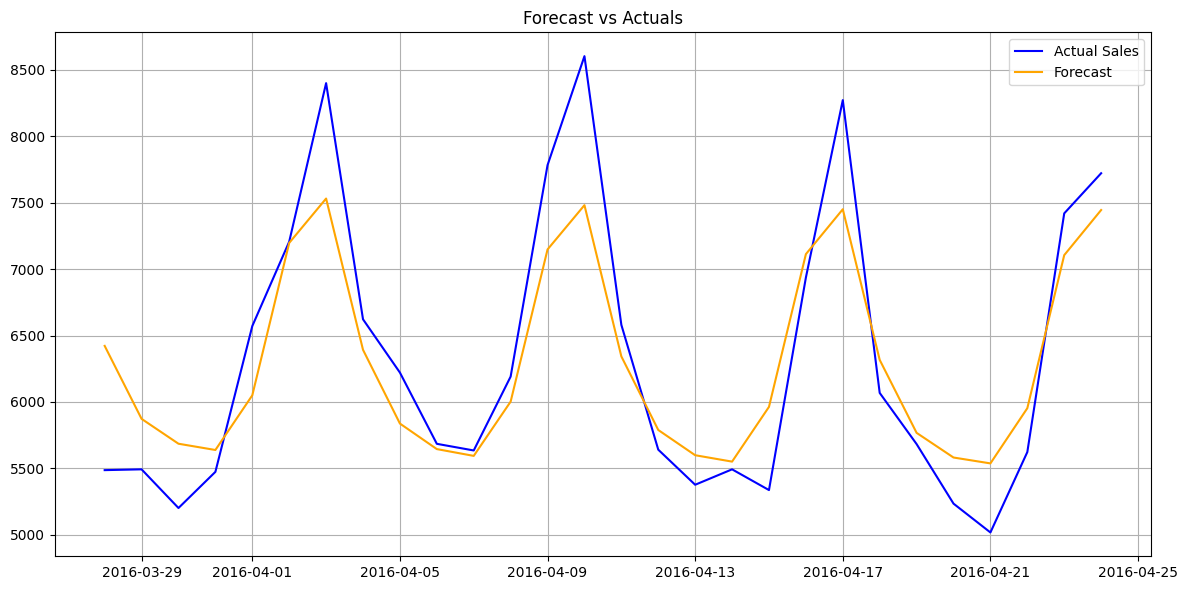

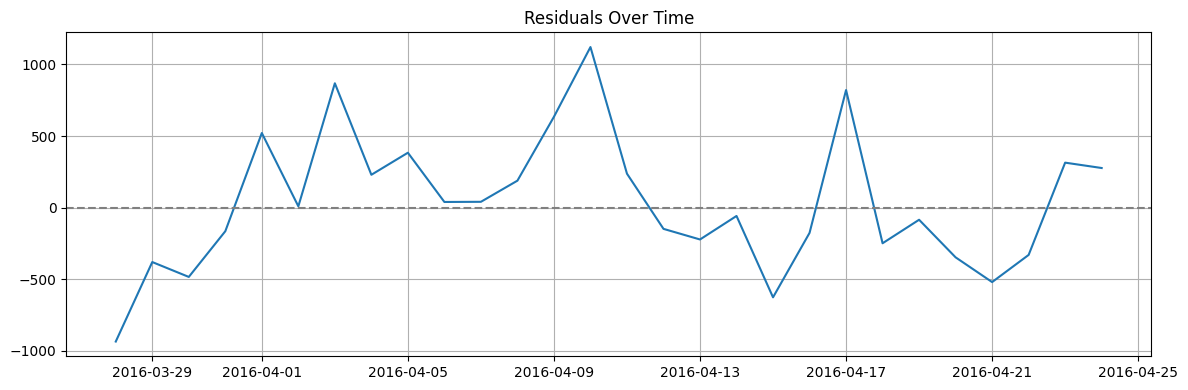

In [8]:
# Split data for forecasting
horizon = 28  # Forecasting 28 days
train_cutoff = df_train["ds"].max() - pd.Timedelta(days=horizon)
df_train_fit = df_train[df_train["ds"] <= train_cutoff].copy()
df_val = df_train[df_train["ds"] > train_cutoff].copy()

## Training
val_model = Prophet()
for col in ["Cultural", "National", "Religious", "Sporting", "None"]:
    val_model.add_regressor(col)

val_model.fit(df_train_fit)

# future dataframe with regressors
future = df_val[
    ["ds"] + ["Cultural", "National", "Religious", "Sporting", "None"]
].copy()

forecast = val_model.predict(future)

df_val = df_val.copy()
df_val["y_pred"] = forecast["yhat"].values

# === Step 5: Compute metrics ===
rmse = np.sqrt(mean_squared_error(df_val["y"], df_val["y_pred"]))
mape = mean_absolute_percentage_error(df_val["y"], df_val["y_pred"])

print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape*100:.2f}%")

plt.figure(figsize=(12, 6))
plt.plot(df_val["ds"], df_val["y"], label="Actual Sales", color="blue")
plt.plot(df_val["ds"], df_val["y_pred"], label="Forecast", color="orange")
plt.title("Forecast vs Actuals")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# === Step 7: Residual Plot ===
plt.figure(figsize=(12, 4))
plt.plot(df_val["ds"], df_val["y"] - df_val["y_pred"], label="Residuals")
plt.axhline(0, color="gray", linestyle="--")
plt.title("Residuals Over Time")
plt.grid()
plt.tight_layout()
plt.show()

In [11]:
## Train over the entire dataset

final_model = Prophet()
for col in ["Cultural", "National", "Religious", "Sporting", "None"]:
    final_model.add_regressor(col)
final_model.fit(df_train)

final_model_path = Path().cwd().parent / "models" / "prophet_model.pkl"
import joblib
joblib.dump(final_model, final_model_path)

23:45:43 - cmdstanpy - INFO - Chain [1] start processing
23:45:44 - cmdstanpy - INFO - Chain [1] done processing


['/home/delen007/qwerty/inventory_forecast/models/prophet_model.pkl']